In [1]:
import pandas as pd
import numpy as np
import gc
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import sys
import re

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import learning_curve, train_test_split, KFold

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import xgbfir
import eli5
%matplotlib inline

In [2]:
train = pd.read_hdf('../input/property.train.h5')
test = pd.read_hdf('../input/property.test.h5') # test set without price

df_all = pd.concat([train, test], sort=False)

In [3]:
df_all['Security:'] = df_all['Security:'].str.lower()
df_all['Security:'].fillna('-1', inplace=True)
df_all.loc[df_all['Security:'].str.contains('24|round'), 'Security:'] = 'full'

condition = df_all['Security:'].isin(['provided', 'is'])
df_all.loc[condition, 'Security:'] = 'yes'
df_all.loc[df_all['Security:'].str.contains('security|guard|protected|secure'), 'Security:'] = 'yes'

condition = df_all['Security:'].isin(['fenced area', 'enclosed courtyard', 'ogorojennaja territory'])
df_all.loc[condition, 'Security:'] = 'closed area'

df_all.loc[df_all['Security:']=='not allowed', 'Security:'] = 'no'
df_all.loc[df_all['Security:']=='cat t', 'Security:'] = 'video surveillance'

condition = df_all['Security:'].isin(['concierge, intercom', 'concierge. doorphone.']) 
df_all.loc[condition, 'Security:'] = 'concierge'

condition = df_all['Security:'].isin(['-1', 'yes', 'closed area', 'full', 'video surveillance', 'concierge', 'no'])
df_all.loc[~condition, 'Security:'] = 'some'

In [4]:
#Change columns with list to string.
col_list = ['breadcrumbs', 'date', 'geo_block', 'owner']
for column in col_list:
    df_all['{}_str'.format(column)] = df_all[column].map(lambda x: ','.join(x))

In [5]:
df_all.loc[df_all['owner_str'].str.contains('@'), 'owner_str'] = 'priv'
counts = df_all['owner_str'].value_counts()
mask = df_all['owner_str'].isin(counts[counts < 5].index)
df_all.loc[mask, 'owner_str'] = 'other'

In [6]:
def bread_geo_func(row): #concatenate breadcrumbs with geo_block, erase repeated values
    bread_str = ','.join(row['breadcrumbs']).lower().strip()
    geo_str = ','.join(row['geo_block']).lower().strip()
    bread_geo_str = (bread_str +','+ geo_str).replace('ул.', 'ул').replace('пер.', 'пер').replace('пр-кт.', 'пр-кт').\
                replace('проезд.', 'проезд').replace('б-р.', 'б-р')
    
    bread_geo = ','.join(sorted(list(set(bread_geo_str.split(',')) - set(['москва', 'г. москва']))))
    
    return bread_geo

df_all['bread_geo_str'] = df_all[['breadcrumbs', 'geo_block']].apply(bread_geo_func, axis=1)

In [7]:
col_to_factorize = [column for column in df_all.columns if (':' in column) or ('_str' in column)]
for column in col_to_factorize:
    df_all['{}_cat'.format(column)] = df_all[column].factorize()[0]

In [8]:
train = df_all[~df_all['price'].isna()]
test = df_all[df_all['price'].isna()]
test = test.drop(['price'], axis=1)
test['id'] = test['id'].astype('int64')

In [14]:
models = [('XGB', XGBRegressor(max_depth=7, n_estimators=100, learning_rate=0.2, random_state=0)),
          ('CB', CatBoostRegressor(depth=7, verbose=False))]

def get_feats(df, del_list=[]):
    feats = df.select_dtypes(include=['number']).columns
    black_list = ['price', 'id'] + del_list
    feats = [f for f in feats if f not in black_list]
    return feats

def run_models(train, feats, models):
    print(feats)
    
    for model_name, model in models:
        X_train, X_test, y_train, y_test = train_test_split(train[feats], train['price'], test_size=0.3, random_state=0)

        y_train  = np.log(y_train)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred = np.exp(y_pred)
        y_pred[y_pred < 0] = 0

        score = mean_absolute_error(y_test, y_pred)
        print('model {}- score: {}'.format(model_name,  score))

def submit(model, train, test, feats, file='model_.csv'):
    X_train = train[feats]
    y_train = np.log(train['price'])
    X_test = test[feats]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.exp(y_pred)
    y_pred[y_pred < 0] = 0
    
    test['price'] = y_pred
    test[ ['id', 'price'] ].to_csv('../output/{}'.format(file), index=False) 
    print('submit for {} \ndone'.format(model))

In [8]:
run_models(train, feats, models)

['Security:_cat', 'Building type:_cat', 'Object type:_cat', 'Ad type:_cat', 'Commission agent:_cat', 'Construction phase:_cat', 'Housing class:_cat', 'Elevator:_cat', 'Bathroom type:_cat', 'Balcony type:_cat', 'Mortgage possible:_cat', 'The view from the window:_cat', 'Garbage chute:_cat', 'Repair:_cat', 'Fridge:_cat', 'Phone:_cat', 'Furniture:_cat', 'Free layout:_cat', 'It is possible to bargain:_cat', 'Floor covering:_cat', 'Room type:_cat', 'Internet:_cat', 'Kitchen furniture:_cat', 'TV:_cat', 'Washing machine:_cat', 'Foundation type:_cat', 'Overlap type:_cat', 'Type of the building:_cat', 'Playground:_cat', 'Class:_cat', 'breadcrumbs_str_cat', 'date_str_cat', 'geo_block_str_cat', 'owner_str_cat']
model XGB- score: 5.834514442053325
model CB- score: 5.723287368178813


In [18]:
# owner : priv
run_models(train, feats, models)

['Security:_cat', 'Building type:_cat', 'Object type:_cat', 'Ad type:_cat', 'Commission agent:_cat', 'Construction phase:_cat', 'Housing class:_cat', 'Elevator:_cat', 'Bathroom type:_cat', 'Balcony type:_cat', 'Mortgage possible:_cat', 'The view from the window:_cat', 'Garbage chute:_cat', 'Repair:_cat', 'Fridge:_cat', 'Phone:_cat', 'Furniture:_cat', 'Free layout:_cat', 'It is possible to bargain:_cat', 'Floor covering:_cat', 'Room type:_cat', 'Internet:_cat', 'Kitchen furniture:_cat', 'TV:_cat', 'Washing machine:_cat', 'Foundation type:_cat', 'Overlap type:_cat', 'Type of the building:_cat', 'Playground:_cat', 'Class:_cat', 'breadcrumbs_str_cat', 'date_str_cat', 'geo_block_str_cat', 'owner_str_cat']
model XGB- score: 5.821164101324759
model CB- score: 5.743797701210726


In [12]:
# owner : priv + <2
run_models(train, feats, models)

['Security:_cat', 'Building type:_cat', 'Object type:_cat', 'Ad type:_cat', 'Commission agent:_cat', 'Construction phase:_cat', 'Housing class:_cat', 'Elevator:_cat', 'Bathroom type:_cat', 'Balcony type:_cat', 'Mortgage possible:_cat', 'The view from the window:_cat', 'Garbage chute:_cat', 'Repair:_cat', 'Fridge:_cat', 'Phone:_cat', 'Furniture:_cat', 'Free layout:_cat', 'It is possible to bargain:_cat', 'Floor covering:_cat', 'Room type:_cat', 'Internet:_cat', 'Kitchen furniture:_cat', 'TV:_cat', 'Washing machine:_cat', 'Foundation type:_cat', 'Overlap type:_cat', 'Type of the building:_cat', 'Playground:_cat', 'Class:_cat', 'breadcrumbs_str_cat', 'date_str_cat', 'geo_block_str_cat', 'owner_str_cat']
model XGB- score: 5.82233893770327
model CB- score: 5.739657770426089


In [17]:
# owner : priv + <5
run_models(train, feats, models)

['Security:_cat', 'Building type:_cat', 'Object type:_cat', 'Ad type:_cat', 'Commission agent:_cat', 'Construction phase:_cat', 'Housing class:_cat', 'Elevator:_cat', 'Bathroom type:_cat', 'Balcony type:_cat', 'Mortgage possible:_cat', 'The view from the window:_cat', 'Garbage chute:_cat', 'Repair:_cat', 'Fridge:_cat', 'Phone:_cat', 'Furniture:_cat', 'Free layout:_cat', 'It is possible to bargain:_cat', 'Floor covering:_cat', 'Room type:_cat', 'Internet:_cat', 'Kitchen furniture:_cat', 'TV:_cat', 'Washing machine:_cat', 'Foundation type:_cat', 'Overlap type:_cat', 'Type of the building:_cat', 'Playground:_cat', 'Class:_cat', 'breadcrumbs_str_cat', 'date_str_cat', 'geo_block_str_cat', 'owner_str_cat']
model XGB- score: 5.788399065261791
model CB- score: 5.747675801543145


In [11]:
# owner : priv + <5 + bread_geo
run_models(train, feats, models)

['Security:_cat', 'Building type:_cat', 'Object type:_cat', 'Ad type:_cat', 'Commission agent:_cat', 'Construction phase:_cat', 'Housing class:_cat', 'Elevator:_cat', 'Bathroom type:_cat', 'Balcony type:_cat', 'Mortgage possible:_cat', 'The view from the window:_cat', 'Garbage chute:_cat', 'Repair:_cat', 'Fridge:_cat', 'Phone:_cat', 'Furniture:_cat', 'Free layout:_cat', 'It is possible to bargain:_cat', 'Floor covering:_cat', 'Room type:_cat', 'Internet:_cat', 'Kitchen furniture:_cat', 'TV:_cat', 'Washing machine:_cat', 'Foundation type:_cat', 'Overlap type:_cat', 'Type of the building:_cat', 'Playground:_cat', 'Class:_cat', 'breadcrumbs_str_cat', 'date_str_cat', 'geo_block_str_cat', 'owner_str_cat', 'bread_geo_str_cat']
model XGB- score: 5.813964516094103
model CB- score: 5.754627088630142


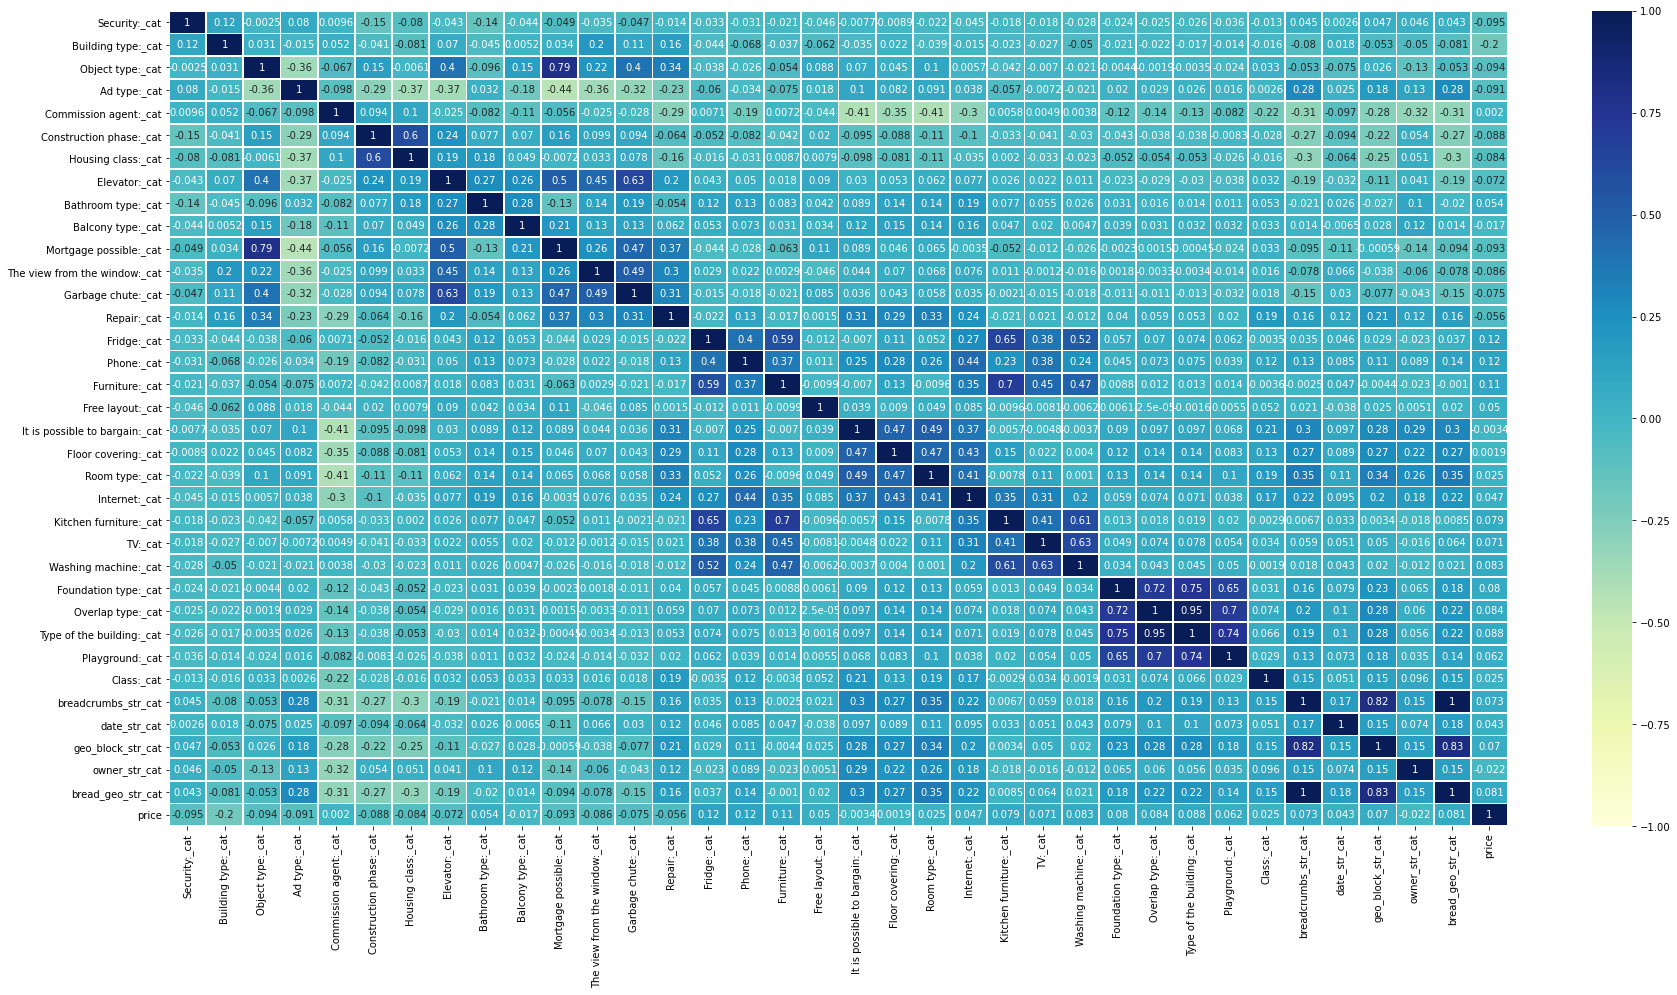

In [12]:
plt.rcParams['figure.figsize']=(30,15)
sns.heatmap(train[feats+['price']].corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

In [13]:
# owner : priv + <5 + bread_geo - del_list
del_list = ['breadcrumbs_str_cat', 'geo_block_str_cat']
feats = [f for f in feats if f not in del_list]
run_models(train, feats, models)

['Security:_cat', 'Building type:_cat', 'Object type:_cat', 'Ad type:_cat', 'Commission agent:_cat', 'Construction phase:_cat', 'Housing class:_cat', 'Elevator:_cat', 'Bathroom type:_cat', 'Balcony type:_cat', 'Mortgage possible:_cat', 'The view from the window:_cat', 'Garbage chute:_cat', 'Repair:_cat', 'Fridge:_cat', 'Phone:_cat', 'Furniture:_cat', 'Free layout:_cat', 'It is possible to bargain:_cat', 'Floor covering:_cat', 'Room type:_cat', 'Internet:_cat', 'Kitchen furniture:_cat', 'TV:_cat', 'Washing machine:_cat', 'Foundation type:_cat', 'Overlap type:_cat', 'Type of the building:_cat', 'Playground:_cat', 'Class:_cat', 'date_str_cat', 'owner_str_cat', 'bread_geo_str_cat']
model XGB- score: 5.902369182265583
model CB- score: 5.852964123626038


In [15]:
# owner : priv + <5 + bread_geo - bread_str
del_list = ['breadcrumbs_str_cat']
feats = get_feats(train, del_list)
run_models(train, feats, models)

['Security:_cat', 'Building type:_cat', 'Object type:_cat', 'Ad type:_cat', 'Commission agent:_cat', 'Construction phase:_cat', 'Housing class:_cat', 'Elevator:_cat', 'Bathroom type:_cat', 'Balcony type:_cat', 'Mortgage possible:_cat', 'The view from the window:_cat', 'Garbage chute:_cat', 'Repair:_cat', 'Fridge:_cat', 'Phone:_cat', 'Furniture:_cat', 'Free layout:_cat', 'It is possible to bargain:_cat', 'Floor covering:_cat', 'Room type:_cat', 'Internet:_cat', 'Kitchen furniture:_cat', 'TV:_cat', 'Washing machine:_cat', 'Foundation type:_cat', 'Overlap type:_cat', 'Type of the building:_cat', 'Playground:_cat', 'Class:_cat', 'date_str_cat', 'geo_block_str_cat', 'owner_str_cat', 'bread_geo_str_cat']
model XGB- score: 5.753284532111753
model CB- score: 5.750923376738445


In [16]:
model = models[0][1]
submit(model, train, test, feats, 'ver3_xgb.csv')

submit for XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 
done


public score on Kaggle: 5.33635